# Pothole Classification

## Load Packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import random
from simple_image_download import simple_image_download as simp
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation,  MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import sklearn
import sklearn.metrics
import skimage.io 
import skimage.segmentation
from sklearn.linear_model import LinearRegression
import copy
import warnings
from PIL import Image
from PIL.ExifTags import TAGS
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import folium
from GPSPhoto import gpsphoto

## Adjust images

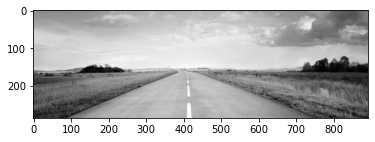

In [3]:
DATASET_LOCATION = "/Users/naty/pothole/Pothole-Detector/Image Data/POTHOLE_DATA"
Categories = ['Not potholes', 'Potholes'] #Not potholes = 0, Potholes = 1

for category in Categories:  
    path = os.path.join(DATASET_LOCATION,category)  
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) #Locates both folders
        plt.imshow(img_array, cmap='gray') #plot image
        break  
    break

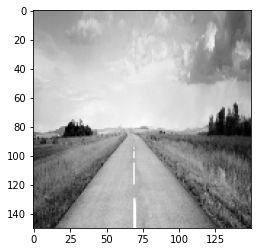

In [4]:
IMG_SIZE = 150 #adjust image size
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #Resize images
plt.imshow(new_array, cmap='gray') #Plot image
plt.show()

##  Load in data

In [10]:
DATASET_LOCATION = "/Users/naty/pothole/Pothole-Detector/Image Data/POTHOLE_DATA"
Categories = ['Not potholes', 'Potholes'] #Not potholes = 0, Potholes = 1
IMG_SIZE = 150
training = []

def train_me():
    for category in Categories:  
        path = os.path.join(DATASET_LOCATION,category)  
        class_num = Categories.index(category) 
        for img in (os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training.append([new_array, class_num])  
            except Exception as e:  
                pass
train_me() 

print(len(training))

1457


/Users/naty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

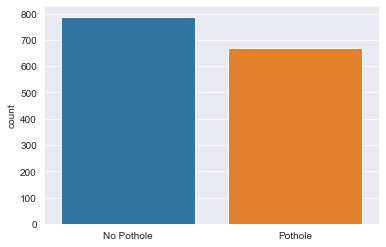

In [11]:
l = []
for i in training:
    if(i[1] == 0):
        l.append("No Pothole")
    else:
        l.append("Pothole")
        
        
sns.set_style('darkgrid')
sns.countplot(l)

In [8]:
random.shuffle(training) #Randomize order of data

In [9]:
for sample in training[:10]:
    print(sample[1])

1
0
1
0
0
1
0
0
0
1


In [10]:
X = []
y = []

for features,label in training:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
y = np.array(y)

## First Simple Model

In [12]:
X = X/255.0 

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=100, epochs=15, validation_split=0.25)

model.save('FIRST.model')

Epoch 1/15
12/12 [==============================] - 82s 7s/step - loss: 2.8004 - accuracy: 0.5056 - val_loss: 0.6532 - val_accuracy: 0.6641
Epoch 2/15
12/12 [==============================] - 75s 6s/step - loss: 0.6055 - accuracy: 0.6951 - val_loss: 0.4990 - val_accuracy: 0.7390
Epoch 3/15
12/12 [==============================] - 74s 6s/step - loss: 0.4741 - accuracy: 0.7778 - val_loss: 0.4435 - val_accuracy: 0.8062
Epoch 4/15
12/12 [==============================] - 72s 6s/step - loss: 0.3959 - accuracy: 0.8303 - val_loss: 0.3915 - val_accuracy: 0.8243
Epoch 5/15
12/12 [==============================] - 72s 6s/step - loss: 0.3335 - accuracy: 0.8553 - val_loss: 0.3792 - val_accuracy: 0.8269
Epoch 6/15
12/12 [==============================] - 72s 6s/step - loss: 0.2469 - accuracy: 0.9173 - val_loss: 0.3658 - val_accuracy: 0.8372
Epoch 7/15
12/12 [==============================] - 81s 7s/step - loss: 0.1934 - accuracy: 0.9302 - val_loss: 0.3814 - val_accuracy: 0.8140
Epoch 8/15
12/12 [==

In [213]:
fsm = tf.keras.models.load_model("FIRST.model")

## Investigate the first model using LIME

In [106]:
explainer = lime_image.LimeImageExplainer()

In [107]:
warnings.filterwarnings('ignore') 
inceptionV3_model = tf.keras.models.load_model("FIRST.model") #Load pretrained model

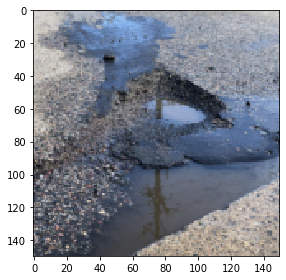

In [109]:
Xi = skimage.io.imread('/Users/naty/pothole/Pothole-Detector/Image Data/Testing/Potholes/1x.jpg')
Xi = skimage.transform.resize(Xi, (150,150)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [110]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

17

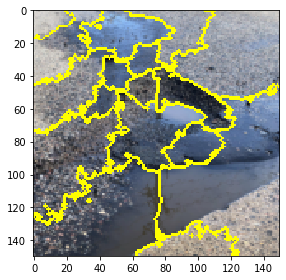

In [111]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [112]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [113]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

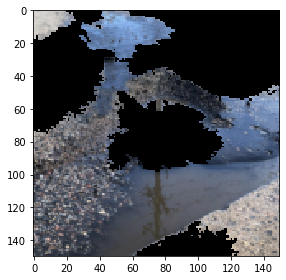

In [114]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

## New model with augmentation

In [58]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])  # brightness

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(train_datagen.flow(X,y,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X.shape[0] // batch_size,
                    verbose=1)

model.save('SECOND.model')

Epoch 1/25
48/48 [==============================] - 26s 541ms/step - loss: 3.4624 - accuracy: 0.5851
Epoch 2/25
48/48 [==============================] - 26s 539ms/step - loss: 1.0889 - accuracy: 0.6365
Epoch 3/25
48/48 [==============================] - 26s 546ms/step - loss: 0.7113 - accuracy: 0.6557
Epoch 4/25
48/48 [==============================] - 26s 547ms/step - loss: 0.7256 - accuracy: 0.7078
Epoch 5/25
48/48 [==============================] - 26s 536ms/step - loss: 0.6833 - accuracy: 0.7131
Epoch 6/25
48/48 [==============================] - 26s 543ms/step - loss: 0.6184 - accuracy: 0.7249
Epoch 7/25
48/48 [==============================] - 26s 546ms/step - loss: 0.5975 - accuracy: 0.7309
Epoch 8/25
48/48 [==============================] - 26s 536ms/step - loss: 0.6092 - accuracy: 0.7474
Epoch 9/25
48/48 [==============================] - 26s 538ms/step - loss: 0.5558 - accuracy: 0.7579
Epoch 10/25
48/48 [==============================] - 27s 559ms/step - loss: 0.5616 - accura

## New model with RGB & larger image sizes

In [3]:
DATASET_LOCATION = "/Users/naty/pothole/Pothole-Detector/Image Data/POTHOLE_DATA"
Categories = ['Not potholes', 'Potholes'] #Not potholes = 0, Potholes = 1
IMG_SIZE_color = 200
training_color = []

def train_me_color():
    for category in Categories:  

        path = os.path.join(DATASET_LOCATION,category)  
        class_num_color = Categories.index(category) 

        for img in (os.listdir(path)):  
            try:
                img_array_color = cv2.imread(os.path.join(path,img))  # convert to array
                new_array_color = cv2.resize(img_array_color, (IMG_SIZE_color, IMG_SIZE_color))  # resize to normalize data size
                training_color.append([new_array_color, class_num_color])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

train_me_color() 

print(len(training_color))

1457


In [4]:
random.shuffle(training_color)

In [5]:
X_color = []
y_color = []

for features,label in training_color:
    X_color.append(features)
    y_color.append(label)

X_color = np.array(X_color).reshape(-1, IMG_SIZE_color, IMG_SIZE_color, 3)  #(how many features, size, size, 1 color array)
y_color = np.array(y_color)

In [7]:
X_color = X_color/255.0

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(200, 200, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_color, y_color, batch_size=100, epochs=15, validation_split=0.25)


tf.keras.models.save_model(model,'my_model.hdf5')
model.save('FOURTH.model')

Epoch 1/15
11/11 [==============================] - 147s 13s/step - loss: 6.1766 - accuracy: 0.5769 - val_loss: 0.5450 - val_accuracy: 0.6712
Epoch 2/15
11/11 [==============================] - 146s 13s/step - loss: 0.3670 - accuracy: 0.8315 - val_loss: 0.3150 - val_accuracy: 0.8658
Epoch 3/15
11/11 [==============================] - 136s 12s/step - loss: 0.2287 - accuracy: 0.9176 - val_loss: 0.3119 - val_accuracy: 0.8658
Epoch 4/15
11/11 [==============================] - 135s 12s/step - loss: 0.1653 - accuracy: 0.9432 - val_loss: 0.3085 - val_accuracy: 0.8822
Epoch 5/15
11/11 [==============================] - 135s 12s/step - loss: 0.1194 - accuracy: 0.9542 - val_loss: 0.6146 - val_accuracy: 0.8384
Epoch 6/15
11/11 [==============================] - 136s 12s/step - loss: 0.0978 - accuracy: 0.9716 - val_loss: 0.3862 - val_accuracy: 0.8603
Epoch 7/15
11/11 [==============================] - 133s 12s/step - loss: 0.0564 - accuracy: 0.9853 - val_loss: 0.5949 - val_accuracy: 0.8548
Epoch 

In [37]:
tf.keras.models.save_model(model,'appothole.m')

INFO:tensorflow:Assets written to: appothole.m/assets


In [146]:
model_color = tf.keras.models.load_model("/Users/naty/pothole/Pothole-Detector/my_model.hdf5")

## Extract metadata from photo and test on photos from Neighborhood

In [58]:
data = gpsphoto.getGPSData('/Users/naty/Downloads/phot/IMG_0502.png')

In [68]:
image = ("/Users/naty/Downloads/IMG_5247.jpg")

In [69]:
def wya(filename):
    inputfile = Image.open(filename)
    lat_card = inputfile._getexif()[0x8825][1]
    long_card = inputfile._getexif()[0x8825][3]
    latitude_direction = inputfile._getexif()[0x8825][2]
    longitude_direction = inputfile._getexif()[0x8825][4]
    return("lat:",lat_card, latitude_direction, 
          "long:", long_card, longitude_direction)

In [70]:
wya('/Users/naty/Downloads/phot/IMG_0502.png')

('lat:', 'N', (35.0, 41.0, 56.08), 'long:', 'E', (139.0, 28.0, 58.37))

In [75]:
def prepare_and_predict(filepath):    
    IMG_SIZE = 200
    img_array = cv2.imread(filepath)  # read in the image, convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    img_reshape = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # return the image 
    prediction = model_color.predict(img_reshape)
    if prediction == np.array([[1.]]):
        print("Pothole locatated at:", wya(image))
    elif prediction == np.array([[0.]]):
        print("Not a pothole. Located at:", wya(image))

In [147]:
prepare_and_predict(image)

Pothole locatated at: ('lat:', 'N', (38.0, 59.0, 58.37), 'long:', 'W', (77.0, 1.0, 28.71))


## Investigate RGB Model

In [14]:
warnings.filterwarnings('ignore') 
inceptionV3_model = model_color

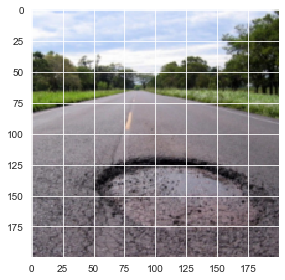

In [15]:
Xi = skimage.io.imread('/Users/naty/pothole/Pothole-Detector/Image Data/Testing/Potholes/4.jpg')
Xi = skimage.transform.resize(Xi, (200,200)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [20]:
np.random.seed(222)
preds = inceptionV3_model.predict(tee1)
#decode_predictions(preds)[0] #Top 5 classes

In [36]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes         

array([0])

In [37]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

26

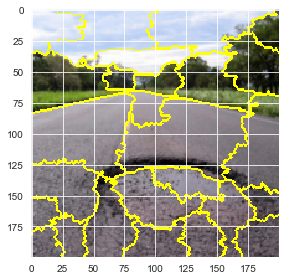

In [38]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [48]:
num_perturb = 200
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1])

In [49]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

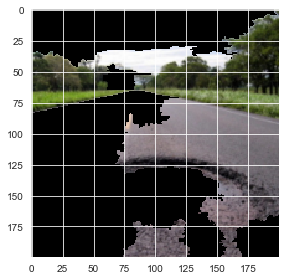

In [50]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [51]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(200, 1, 1)

In [52]:
original_image = np.ones(num_superpixels)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(200,)

In [53]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
weights.shape

(200,)

In [54]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 1.66985531e-01, -4.35711673e-02, -4.40280394e-02,  3.61366178e-02,
        8.23340222e-02, -1.35879240e-02, -4.71817777e-01, -6.72463103e-02,
       -7.47249403e-02,  2.11125085e-02,  5.35388505e-02,  4.17799621e-02,
       -4.40017945e-02, -8.92908741e-03,  1.99211268e-02,  4.34942752e-04,
        5.74267210e-03,  4.49873566e-02,  2.67661137e-01,  2.83958113e-02,
       -1.59422190e-01, -6.32066476e-02, -1.05826306e-01,  4.10783078e-02,
       -5.34956937e-02,  6.35002285e-02])

In [55]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([25,  4,  0, 18])

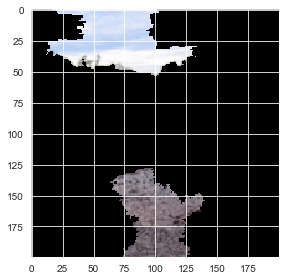

In [56]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

## Create map pin using photo metadata

In [142]:
def map_me(image):    
    coordinates = wya(image)
    lat = coordinates[2]
    long = coordinates[5]
    decimal_degrees = int(lat[0]) + int(lat[1]) / 60 + int(lat[2]) / 3600
    neg_decimal_degrees = (int(long[0]) + int(long[1]) / 60 + int(long[2]) / 3600)*(-1)
    map = folium.Map(location=[decimal_degrees, neg_decimal_degrees],
                 zoom_start=20, control_scale=True)
    folium.Marker(location=[decimal_degrees, neg_decimal_degrees]).add_to(map)
    return(map)

In [143]:
map_me("/Users/naty/Downloads/IMG_5247.jpg")